# Evaluate model for Vietnamese Stock Env

In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())
os.chdir(path.parent.absolute())

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pandas_ta as ta
from stable_baselines3 import PPO, SAC
import gym
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy
import mt4_hst
import stock_env
from stock_env.utils import *
from stock_env.envs import *
from stock_env.feature.feature_extractor import *
from stable_baselines3.common.env_checker import check_env
%matplotlib inline

In [ ]:
env = 'MultiStockContinuousEnv'
algo = 'ppo'
path = "../stock_datasets/"
feature_extractor = TrendFeatures()
name = f"{algo}_{env}_{feature_extractor.__class__.__name__}"
# name = 'ppo_MultiStockContinuousEnv_TrendFeatures'

# Total Portfolio

In [ ]:
total_name = f'histories_{name}'
df = pd.read_csv(f'temp/history/{total_name}.csv')
df.sort_values(by='time', inplace=True)
df.index = pd.to_datetime(df['time'])
portfolio_value = df['total_portfolio_value']
create_performance(portfolio_value.pct_change())

# Ticker history

In [57]:
# ticker = 'SSI'
# ticker_name = f'ticker_history_{ticker}_{name}'

# for signal stock
# env = 'VietnamStockContinuousEnv'
# algo = 'ppo'
# ticker = "SSI"
# path = "../stock_datasets/"
# feature_extractor = TrendFeatures()
# ticker_name = f"{algo}_{env}_{feature_extractor.__class__.__name__}_{ticker}"

# specify name
ticker_name = "SAC_RandomStockEnv_TrendFeatures_finservice"

df = pd.read_csv(f'temp/history/{ticker_name}.csv')
df.sort_values(by='time', inplace=True)
df.index = pd.to_datetime(df['time'])
portfolio_value = df['portfolio_value']

In [58]:
df['ticker'].unique()

array(['HCM'], dtype=object)


    Annual return     : -1.25%
    Cumulative return : -15.04%
    Sharpe ratio      :  0.04
    Maximum Drawdown  : -54.68%
    Annual Volatility :  20.28%
    Value-At-Risk     :  nan%
    


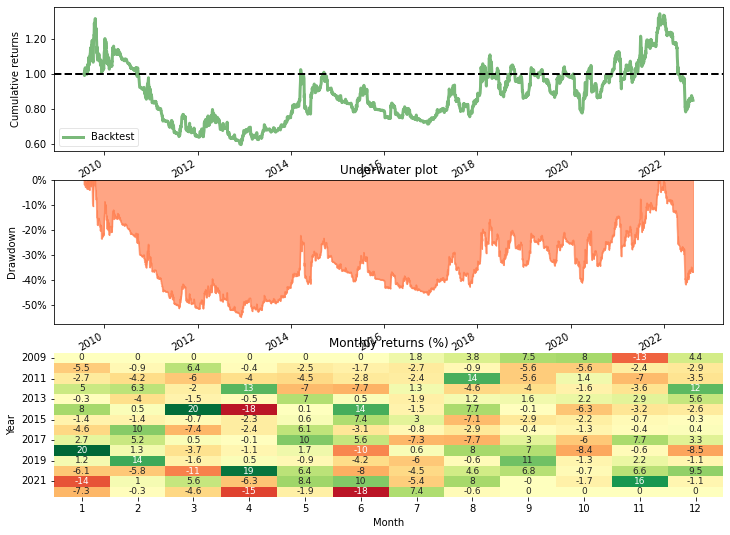

In [59]:
create_performance(portfolio_value.pct_change())

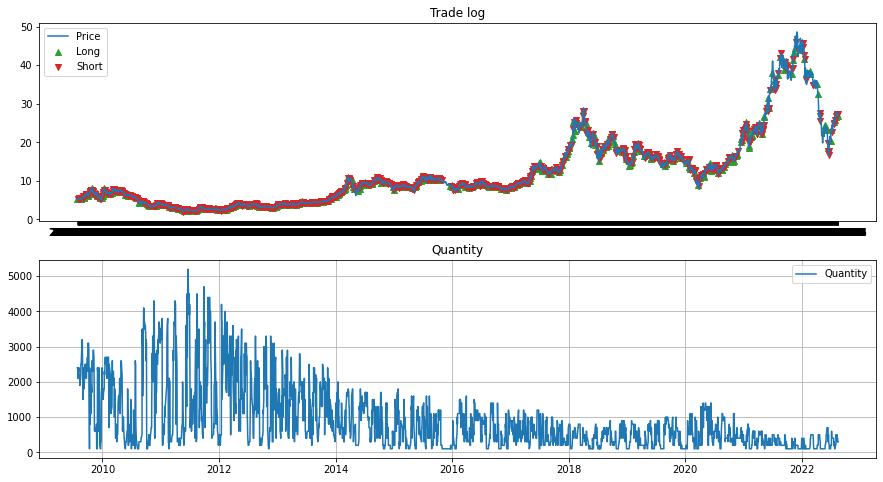

In [60]:
plot_trade_log_v2(df)

# Evaluate Random Stock Env Agent

In [61]:
tickers = ["BSI"]
path = "../stock_datasets/"
feature_extractor = TrendFeatures()

env = RandomStockEnv(
    tickers = tickers,
    data_folder_path = path,
    feature_extractor = feature_extractor
)
from stable_baselines3 import SAC
# model = PPO.load("log/PPO_RandomStockEnv_TrendFeatures_10stocks.zip", env=env)
model = SAC.load("log/SAC_RandomStockEnv_TrendFeatures_finservice.zip", env=env)

# run model to get detailed information in the enviroment
done = False
obs = env.reset(eval_mode=True)
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, _ = env.step(action)

# get data
df = env.get_history()
df.sort_values(by='time', inplace=True)
df.index = pd.to_datetime(df['time'])
portfolio_value = df['portfolio_value']

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.



    Annual return     :  16.98%
    Cumulative return :  440.48%
    Sharpe ratio      :  0.57
    Maximum Drawdown  : -64.58%
    Annual Volatility :  44.65%
    Value-At-Risk     :  nan%
    


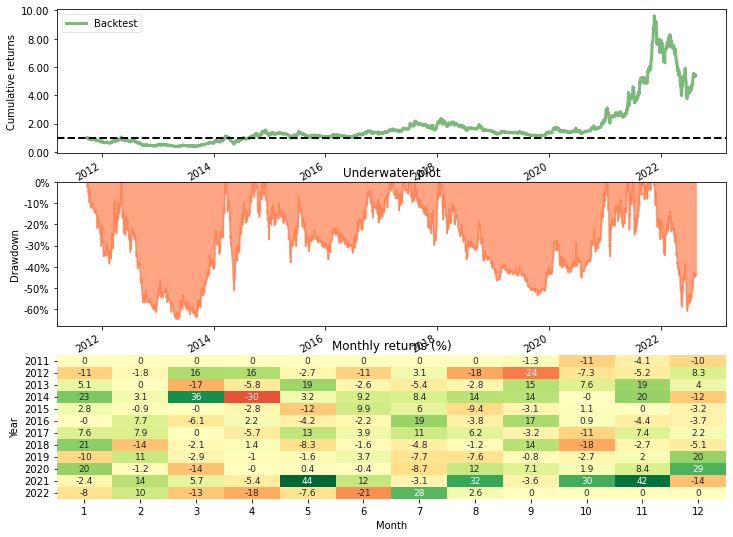

In [62]:
create_performance(portfolio_value.pct_change())

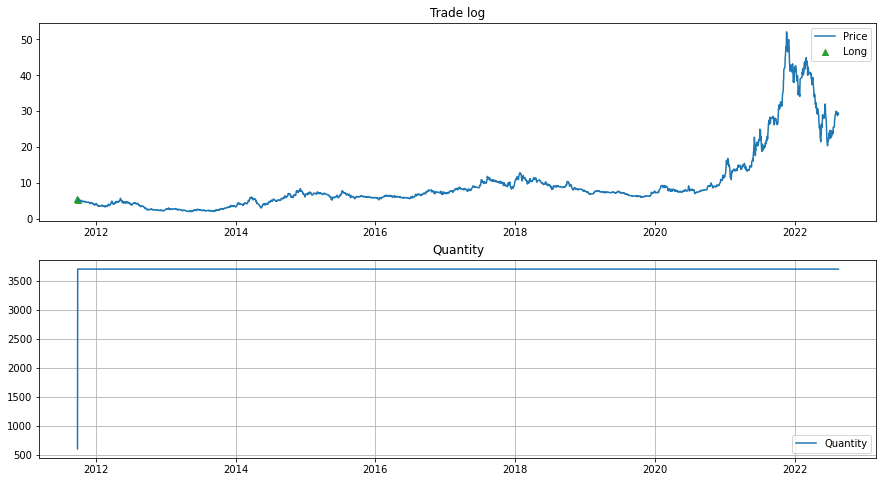

In [64]:
plot_trade_log_v2(df)